In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import frangi

# *Read Gambar*

<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:2: SyntaxWarning: invalid escape sequence '\i'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_24312\94632917.py:2: SyntaxWarning: invalid escape sequence '\i'
  image_path = "Testdata\im0001.ppm"


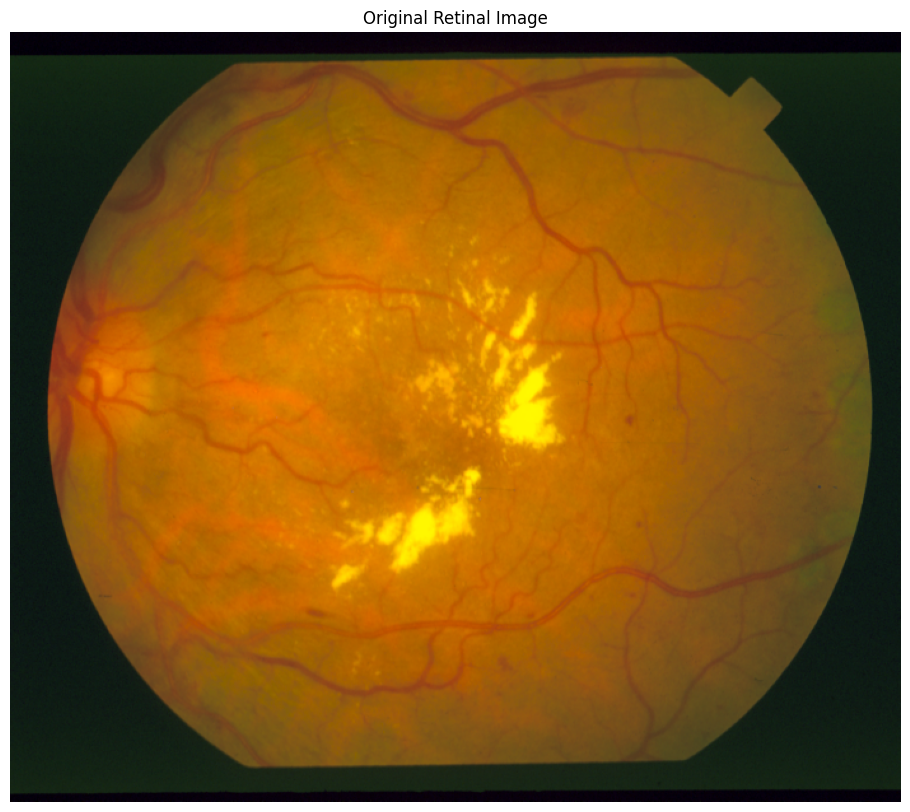

In [62]:
# Membaca gambar dari path yang diberikan
image_path = "Testdata\im0001.ppm"
raw_image = cv2.imread(image_path)

# Mengubah gambar dari BGR (OpenCV format) ke RGB (matplotlib format)
raw_image_rgb = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)

# Menampilkan gambar asli (Raw Image)
plt.figure(figsize=(20, 10))
plt.title("Original Retinal Image")
plt.imshow(raw_image_rgb)
plt.axis('off')
plt.show()

# MASKING GAMBAR

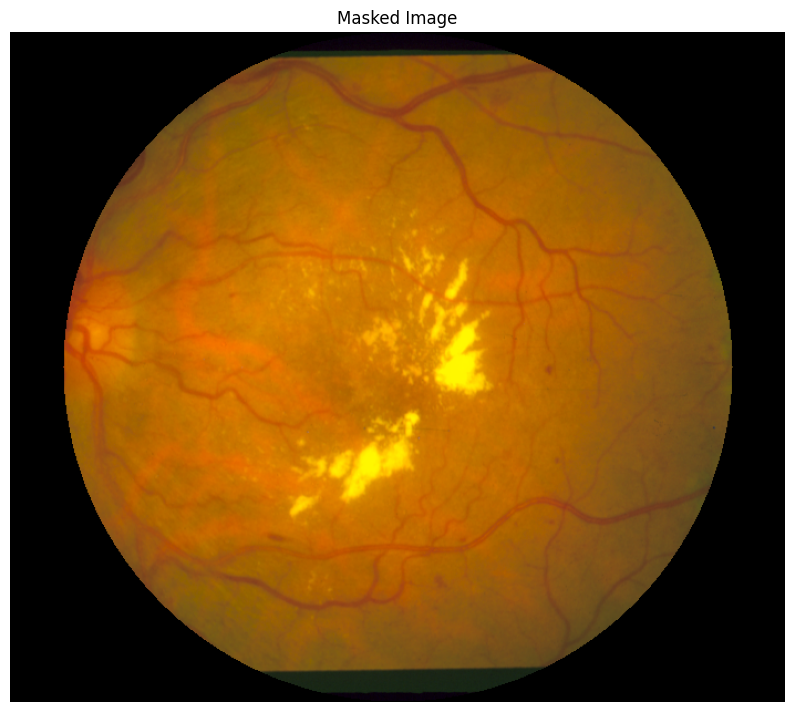

In [63]:
# Membuat masker dengan ukuran yang sama dengan gambar
mask = np.zeros(raw_image.shape[:2], dtype="uint8")

# Mendefinisikan pusat dan radius dari masker bundar
(h, w) = raw_image.shape[:2]
center = (w // 2, h // 2)
radius = min(center[0], center[1], w - center[0], h - center[1])

# Menggambar lingkaran putih di tengah masker hitam (0) dengan radius tertentu
for i in range(h):
    for j in range(w):
        if (i - center[1])**2 + (j - center[0])**2 <= radius**2:
            mask[i, j] = 255

# Terapkan masker pada gambar
masked_image = cv2.bitwise_and(raw_image_rgb, raw_image_rgb, mask=mask)

# Menampilkan gambar yang telah di-mask
plt.figure(figsize=(10, 10))
plt.title("Masked Image")
plt.imshow(masked_image)
plt.axis('off')
plt.show()


# Gray Scale

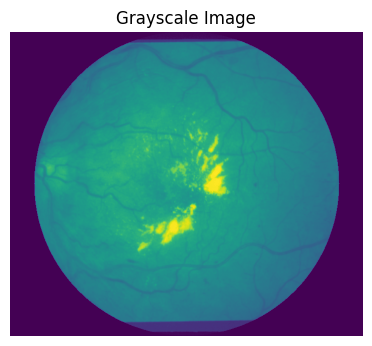

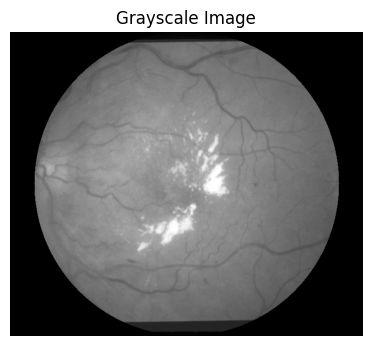

In [64]:
# Konversi gambar ke grayscale secara manual
gray_image = np.zeros((h, w), dtype="float32")
for i in range(h):
    for j in range(w):
        if mask[i, j] == 255:
            R = masked_image[i, j, 0]
            G = masked_image[i, j, 1]
            B = masked_image[i, j, 2]
            gray_value = 0.2989 * R + 0.5870 * G + 0.1140 * B
            gray_image[i, j] = np.clip(gray_value, 0, 255) 

gray_image = (gray_image * 255 / gray_image.max()).astype("uint8")
# Menampilkan gambar grayscale
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title("Grayscale Image")
plt.imshow(gray_image, vmin=0, vmax=255)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 2)
plt.title("Grayscale Image")
plt.imshow(gray_image,cmap='gray',vmin=0, vmax=255)
plt.axis('off')
plt.show()

# Adaptive Histogram Equalization (CLAHE)

(-0.5, 699.5, 604.5, -0.5)

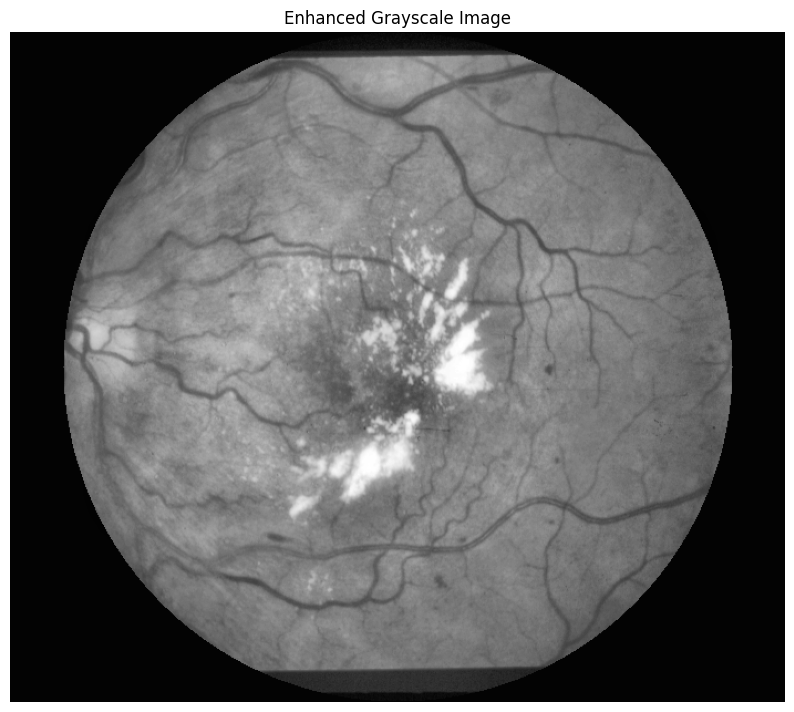

In [65]:

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_gray_image = clahe.apply(gray_image)

plt.figure(figsize=(10, 10))
plt.title("Enhanced Grayscale Image")
plt.imshow(enhanced_gray_image, cmap='gray', vmin=0, vmax=255)
plt.axis('off')


# Vessel Detecting using Frangi

In [79]:
gray_image2 = masked_image[:,:,1]

In [96]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized = clahe.apply(gray_image2)
gaussian_filtered = cv2.GaussianBlur(equalized, (5, 5), 0)

In [97]:
denoised = cv2.fastNlMeansDenoising(gaussian_filtered, None, 15)

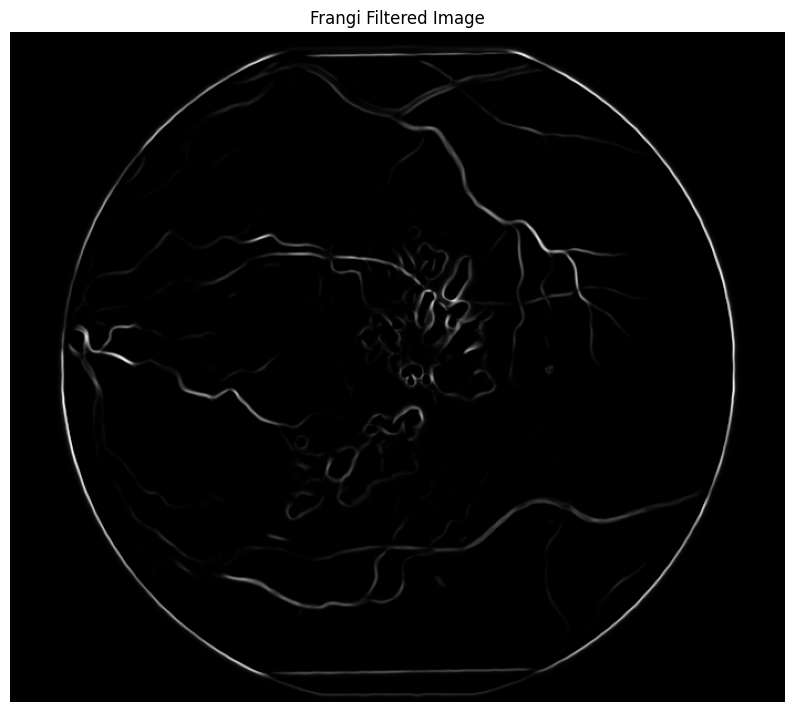

In [98]:
def normalize(image: np.ndarray, factor: float) -> np.ndarray:
    image = image * (factor / image.max())
    return image

vessels = frangi(denoised)
vessels = normalize(vessels, 255).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.title("Frangi Filtered Image")
plt.imshow(vessels, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

(-0.5, 699.5, 604.5, -0.5)

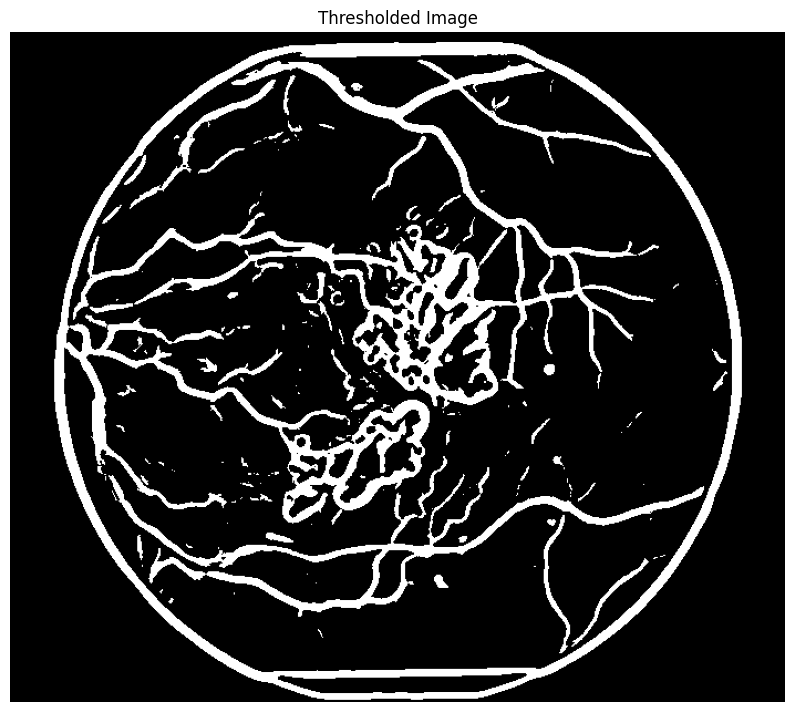

In [99]:
_, thresh = cv2.threshold(vessels, 0, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 10))
plt.title("Thresholded Image")
plt.imshow(thresh, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

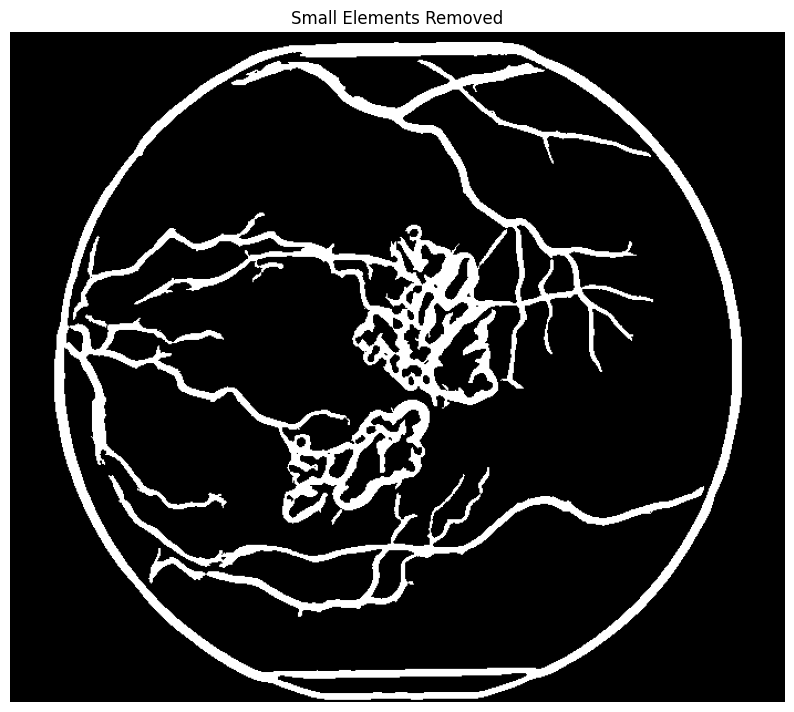

In [100]:
def remove_small_elements(image: np.ndarray, min_size: int) -> np.ndarray:
    components, output, stats, _ = cv2.connectedComponentsWithStats(
        image, connectivity=8)

    sizes = stats[1:, -1]
    width = stats[1:, -3]
    height = stats[1:, -2]
    components -= 1

    result = np.zeros((output.shape))

    for i in range(0, components):
        if sizes[i] >= min_size and (width[i] > 150 or height[i] > 150):
            result[output == i + 1] = 255

    return result

small_removed = remove_small_elements(thresh, 800).astype(np.uint8)
plt.figure(figsize=(10, 10))
plt.title("Small Elements Removed")
plt.imshow(small_removed, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

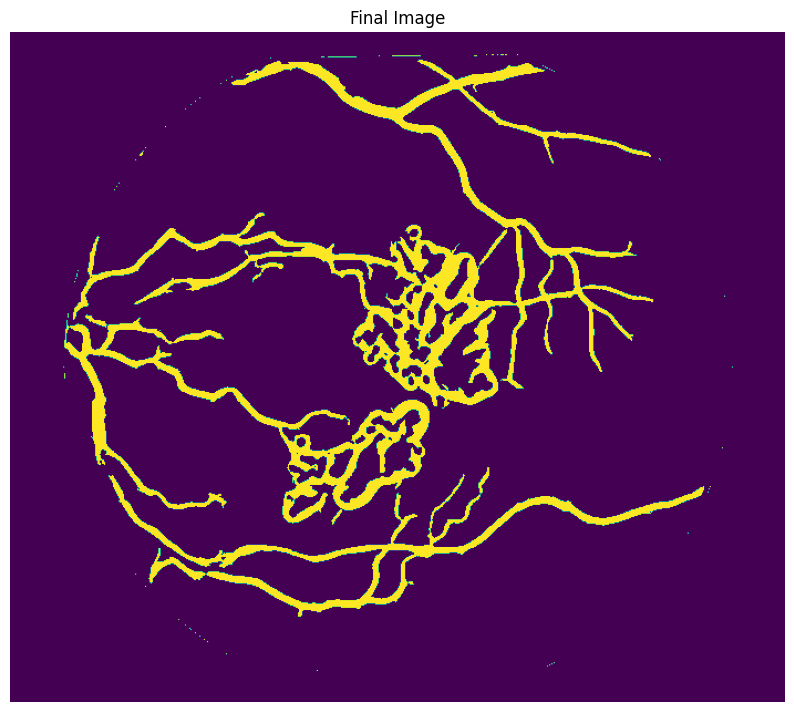

In [101]:
def remove_border(color_img: np.ndarray, image: np.ndarray) -> np.ndarray:
    hsv = cv2.cvtColor(color_img, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 0, 80])
    upper = np.array([255, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)
    
    return cv2.bitwise_and(image, mask)

end_result = remove_border(masked_image, small_removed)
plt.figure(figsize=(10, 10))
plt.title("Final Image")
plt.imshow(end_result)
plt.axis('off')
plt.show()

# Vessel Detecting

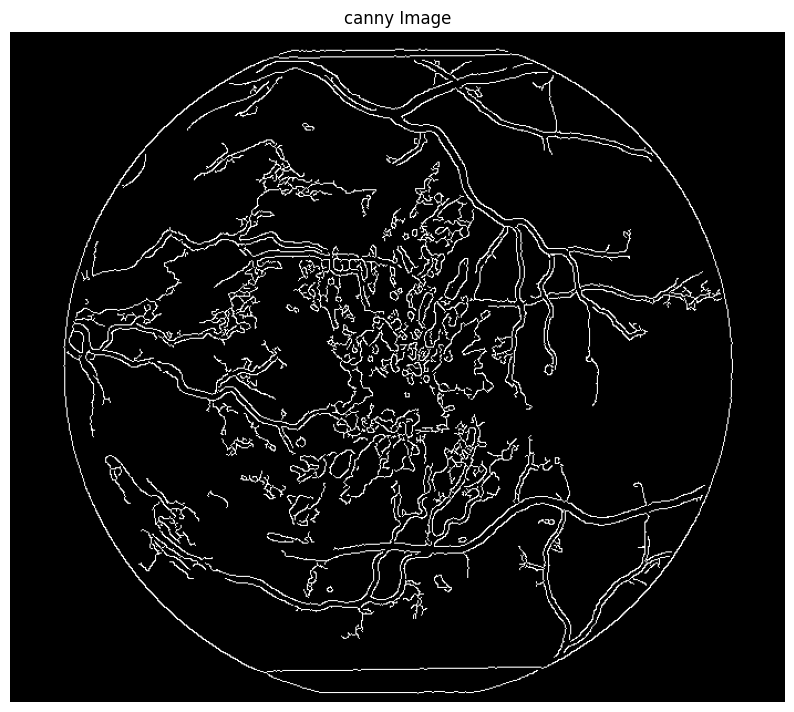

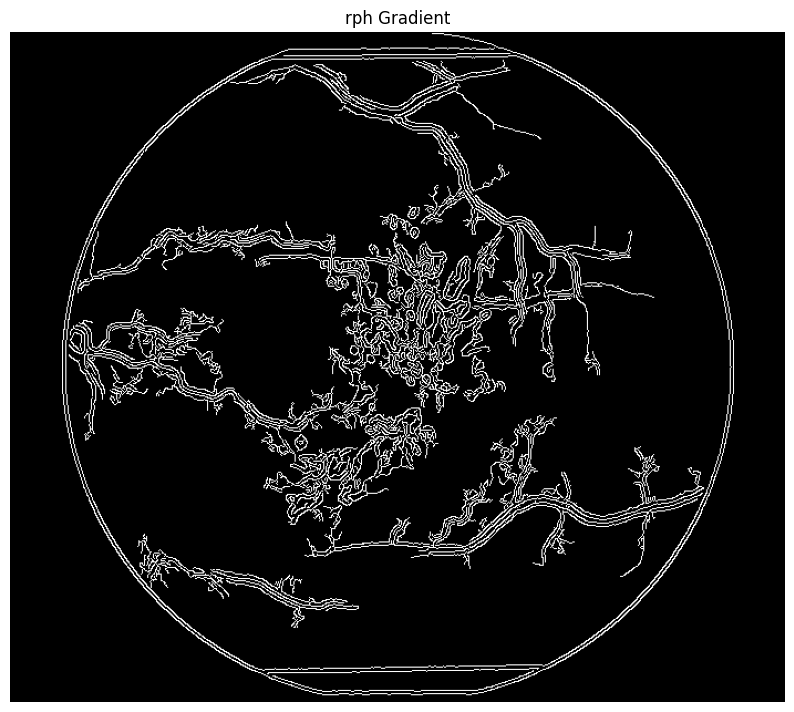

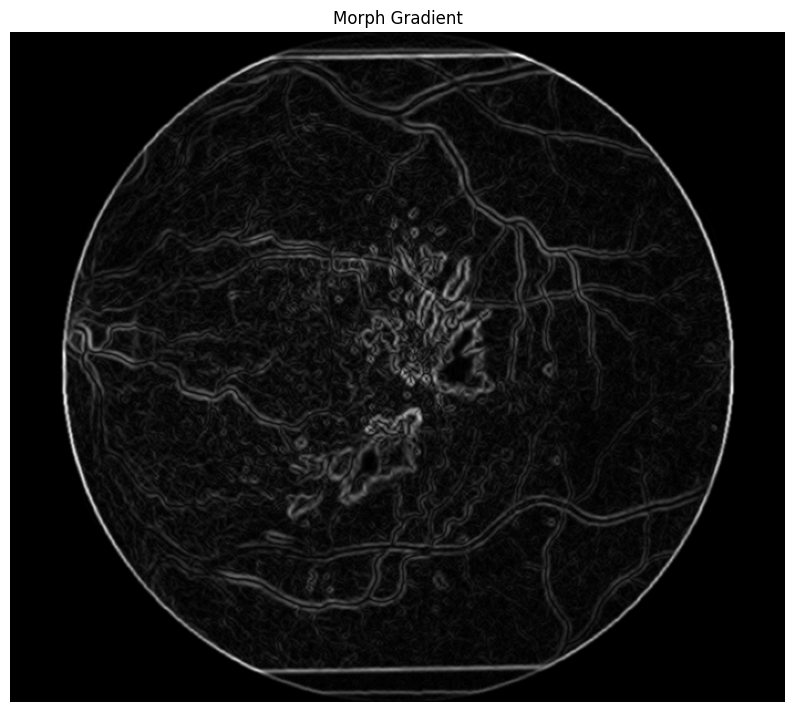

In [102]:
# Step 2: Gaussian Blur untuk mengurangi noise
blurred_image = cv2.GaussianBlur(enhanced_gray_image, (5, 5), 0)

# Step 3: Canny Edge Detection untuk mendeteksi tepi pembuluh darah
vessel_image = cv2.Canny(blurred_image, 10, 90)
Morph_grad = cv2.morphologyEx(blurred_image, cv2.MORPH_GRADIENT, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
canney = cv2.Canny(Morph_grad, 10, 90)


plt.figure(figsize=(10, 10))
plt.title("canny Image")
plt.imshow(vessel_image, cmap='gray')
plt.axis('off')

plt.figure(figsize=(10, 10))
plt.title("rph Gradient")
plt.imshow(canney, cmap='gray')
plt.axis('off')

plt.figure(figsize=(10, 10))
plt.title("Morph Gradient")
plt.imshow(Morph_grad, cmap='gray')
plt.axis('off')
plt.show()

(-0.5, 699.5, 604.5, -0.5)

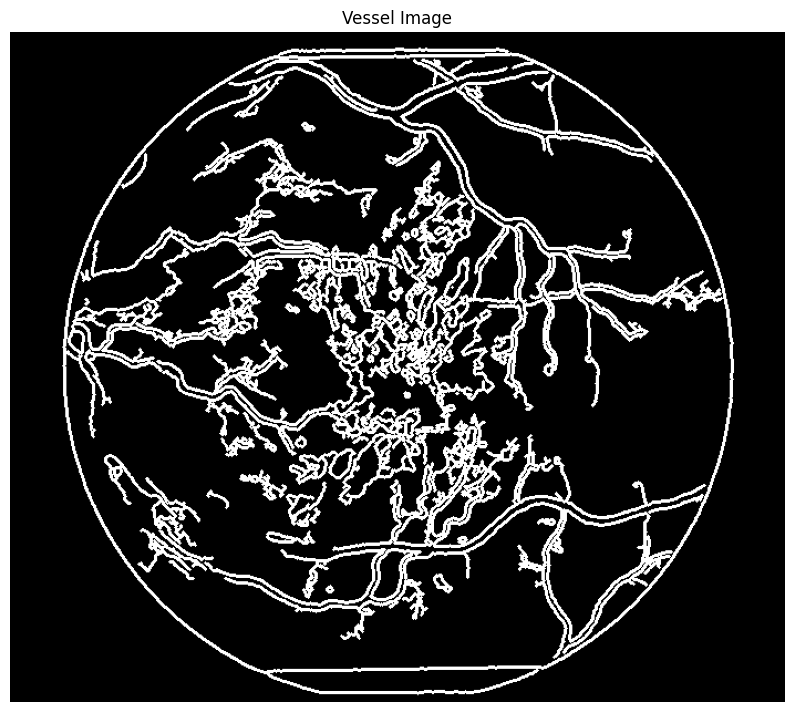

In [103]:

# Melakukan operasi morfologi untuk meningkatkan kontras vessel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
tophat = cv2.morphologyEx(enhanced_gray_image, cv2.MORPH_TOPHAT, kernel)
Morph = cv2.morphologyEx(vessel_image, cv2.MORPH_GRADIENT, kernel)

# Melakukan thresholding untuk mendapatkan vessel
_, vessel = cv2.threshold(Morph, 30, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 10))
plt.title("Vessel Image")
plt.imshow(Morph, cmap='gray')
plt.axis('off')